# Kendrick Mass Filter 
 __Authors:__ Ricardo R. da Silva (ridasilva@ucsd.edu), Madeleine Ernst (mernst@ucsd.edu), Alan K. Jarmusch (ajarmusch@ucsd.edu) <br>
 __Verion:__ 1.0 (Prior to Submission of Manuscript) <br>
 __Date of Last Revision:__ 06-21-2018 <br>
 
**Description**: Kendrick mass is the mass-to-charge (*m/z*) of each ion rescaled to an integer value of a given unit repeat. The defect between the Kendrick scaled *m/z* and the integer Kendrick mass value, i.e. Kendrick mass defect (KMD), is similar between homologous compounds. The Kendrick Mass Filter (MDF) is used to perform selection and removal of data centered around a user-defined KMD, with addtional restrictions on the elution time and presence of possibly multiple homologous compounds eluting together. This notebook calculates and visualizes data output obtained through the Kendrick Mass Filter for a selected dataset using user-defined parameters.

**Input**: <br>
<ul>
<li>**Feature table**: (.csv) file with MS features in columns and samples in rows. Feature IDs are provided in the column names in the following format: "mz;RT". The first column must contain sample names. </li>
</ul> <br>
**Output**: <br>
<ul>
<li>**Summary tables**: (.csv) files containing Kendrick mass filtered output data. </li>
<li>**Plots** (.pdf): Kendrick mass plot, MS1 features plot and spectra before and after applying KMF.</li>
</ul> <br> 
**Dependencies**: R version 3.4.2 (2017-09-28) and packages: tidyr_0.8.0, dplyr_0.7.4, gridExtra_2.3, gtable_0.2.0, Rgraphviz_2.22.0, graph_1.56.0, BiocGenerics_0.24.0, Hmisc_4.0-3, ggplot2_2.2.1, Formula_1.2-2, survival_2.41-3, lattice_0.20-35 

load libraries

In [1]:
library(Hmisc)
library(Rgraphviz)
library(graph)
library(ggplot2)
library(gtable)
library(grid)
library(gridExtra)
library(dplyr)
library(tidyr)

Loading required package: lattice
Loading required package: survival
Loading required package: Formula
Loading required package: ggplot2

Attaching package: 'Hmisc'

The following objects are masked from 'package:base':

    format.pval, units

Loading required package: graph
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: 'BiocGenerics'

The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs

The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pma

load Kendrick Mass Filter source function

In [2]:
source("kendrick.mass.filter_new_all_datamatrix_terminologyupdate.R")

# Data Input and Preparation for Kendrick Mass Filter

load data matrix (samples in rows and variables in columns)

In [1]:
data_matrix <- read.csv("Featuretable.csv", header=T, check.names=F)

Prepare data for Kendrick Mass Filter: create a matrix containing one column with *m/z* values and another column with RT values

In [4]:
vec <- do.call(rbind,lapply(strsplit(colnames(data_matrix)[2:ncol(data_matrix)],";"),matrix,ncol=2,byrow=TRUE))
class(vec) <- "numeric"
colnames(vec)<- c("mz","rt")
head(vec)

mz,rt
356.3886,7.804624
367.3320,6.990095
482.5283,8.711017
328.3572,7.900973
282.2789,9.140700
328.3573,7.387778


In [5]:
dim(data_matrix)

[1]   83 4361

# Apply Kendrick Mass Filter to data
Parameters, which can be specified when running the mass filter: <br>
1. __Kendrick mass defect (KMD) [Da]__ - tolerance of mass defect. Smaller values result in a more stingent homology parameter. <br>
2. __Retention time (RT) [min]__ - tolerance for chromatographic elution. <br>
3. __Number of Observations (NOS)__ - how many oligomer peaks must be observed. Larger values result in more specificity. 
4. __connection_filter__ must be set to "TRUE" for NOS parameter to function correctly. <br>
5. __polymer__ - selection of polymers or signals to filter, options are:<br>
alkane_other_CH2, oxidation, water_cluster, alkane_C2H4, methanol_cluster, acetonitrile_cluster, propylation_other_C3H6, polyethylene_glycol_other_C2H4O1, perfluoro_CF2, ammoniumchloride_cluster, butylation_other_C4H8, sodiumchloride_cluster, polypropylene_glycol_other_C3H6O1, ammoniumformate_cluster, sodiumformate_cluster, potassiumchloride_cluster, polysiloxane, <br> sodiumacetate_cluster

run the Kendrick Mass Filter with user-specified parameters

In [6]:
output <- Kendrick.mass.filter(
    data_matrix, 
    vec,
    polymer = "polyethylene_glycol_other_C2H4O1", 
    KMD = 0.01, 
    RT = 0.8, 
    NOS = 5, 
    connection_filter = TRUE)

show output table

# Kendrick Mass Plot

create Kendrick mass plot

In [8]:
kendrickmassfilterinfo <- as.data.frame(output$kendrickmassfilterinfo_original)
kendrickmassfilterinfo_filtered_wgraph <- as.data.frame(output$kendrickmassfilterinfo_filtered_wgraph)
kendrickmassfilterinfo_diff <- kendrickmassfilterinfo[((kendrickmassfilterinfo[,1] %in% 
                                                        kendrickmassfilterinfo_filtered_wgraph[,1]) & 
                                                       (kendrickmassfilterinfo[,2] %in% 
                                                        kendrickmassfilterinfo_filtered_wgraph[,2])) != TRUE,]

Original MS1 features are displayed in black, and filtered MS1 features in red. Homologous compounds (polymers) can be readily identified by plotting the integer Kendrick values versus the Kendrick mass defect, resulting in a horizontal alignment in the Kendrick mass plot. 

Saving 6.67 x 6.67 in image


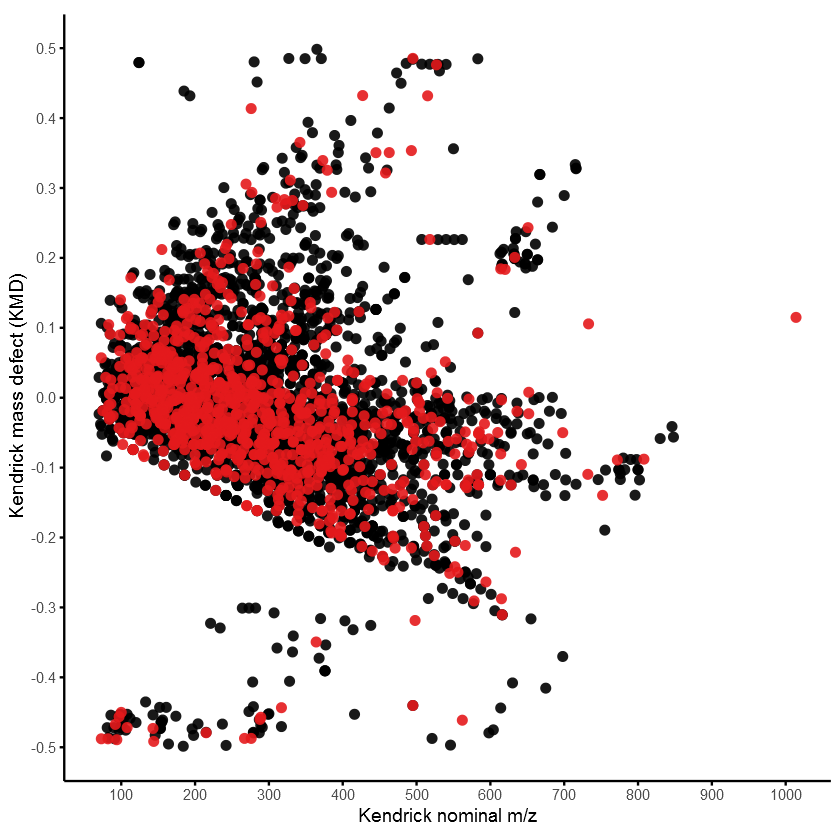

In [9]:
Kendrickplot <- 
    ggplot()+
    geom_point(data=as.data.frame(output$kendrickmassfilterinfo_filtered_wgraph), aes(x=nom_kend, y=msdefect), pch=16, 
               size=2.5, alpha=0.9, col="black")+
    geom_point(data=kendrickmassfilterinfo_diff,aes(x=nom_kend,y=msdefect), pch=16, 
               size=2.5, alpha=0.9,  col="#e41a1c")+
    scale_y_continuous(breaks = seq(-0.5,0.5,0.1))+
    scale_x_continuous(breaks = seq(0,1000,100))+
    xlab("Kendrick nominal m/z") +
    ylab("Kendrick mass defect (KMD)") +
    theme_minimal() +
    theme(panel.grid.major=element_blank(),panel.grid.minor=element_blank(),
               axis.line=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.ticks=element_line(colour ="black",size=0.5, linetype="solid"),
               panel.background = element_rect(fill="white", colour="white", size=0.5, linetype="solid"),
               legend.position="bottom",
               legend.background = element_rect(fill="white",size=0.25,linetype="blank"),
               legend.title = element_text("DBS Features Filtered"),
               legend.text=element_text(size=6)) +
    theme(aspect.ratio=1)
print(Kendrickplot)
ggsave("Kendrickmassplot_Autism_0.01_0.8_5_V1.1.pdf")

Following Fouquet and Sato (Anal. Chem. 2017, 89, 2682−2686) definitions of KM as


\begin{equation}
KM(ion) = m/z(ion) * \frac{round(m(base\ unit))}{m(base\ unit)}
\end{equation}

NKM as

\begin{equation}
NKM(ion) = round(KM(ion)) 
\end{equation}

and KMD as

\begin{equation}
KMD(ion) = NKM(ion) - KM(ion)
\end{equation}

and CNKM as

\begin{equation}
CNKM(ion) = NKM(ion) - celling(NKM(ion)-m/z(ion))
\end{equation}

The expansion of the KMD dimension is accomplished using a fractional base unit 

\begin{equation}
base\ unit = \frac{(base\ unit)}{X}
\end{equation}

# MS1 Feature Plot

create MS1 feature plot

In [10]:
#colnames(output$Kendrickfiltered_MS1features_wgraph)
KMF_vec <- do.call(rbind,lapply(strsplit(colnames(output$Kendrickfiltered_MS1features_wgraph)[2:ncol(output$Kendrickfiltered_MS1features_wgraph)],";"),matrix,ncol=2,byrow=TRUE))
class(KMF_vec) <- "numeric"
colnames(KMF_vec)<- c("mz","rt")
head(KMF_vec)

mz,rt
356.3886,7.804624
367.3320,6.990095
482.5283,8.711017
282.2789,9.140700
172.1329,8.829460
370.3669,8.671656


In [11]:
Filtered_matrix_KMF_wgraph_MS1_plot_vec <- as.data.frame(vec[((vec[,1] %in% KMF_vec[,1]) & (vec[,2] %in% KMF_vec[,2])) != TRUE,])

Original MS1 features are displayed in black, and filtered MS1 features in red.

Saving 6.67 x 6.67 in image


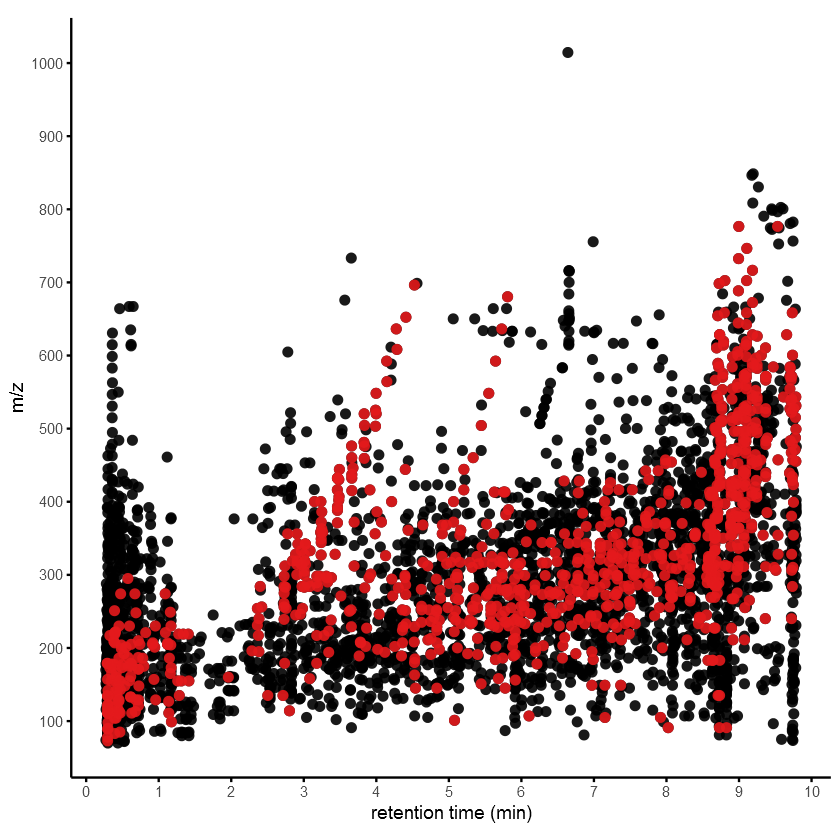

In [12]:
MS1featureplot <- 
    ggplot()+
    geom_point(data=as.data.frame(vec),aes(x=rt, y=mz), pch=16, 
              size=2.5, alpha=0.9, color="black")+
    geom_point(data=Filtered_matrix_KMF_wgraph_MS1_plot_vec, aes(x=rt, y=mz), pch=16, 
               size=2.5, alpha=0.9, col="#e41a1c")+
    scale_y_continuous(breaks = seq(0,1000,100))+
    scale_x_continuous(breaks = seq(0,10,1))+
        xlab("retention time (min)") +
        ylab("m/z") +
    theme_minimal() +
        theme(panel.grid.major=element_blank(),panel.grid.minor=element_blank(),
               axis.line=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.ticks=element_line(colour ="black",size=0.5, linetype="solid"),
               panel.background = element_rect(fill="white", colour="white", size=0.5, linetype="solid"),
               legend.position="bottom",
               legend.background = element_rect(fill="white",size=0.25,linetype="blank"),
               legend.title = element_text("DBS Features Filtered"),
               legend.text=element_text(size=6)) +
    theme(aspect.ratio=1)
print(MS1featureplot)
ggsave("MS1featureplot_Autism_V1.1.pdf")

# Plot Spectra

create MS1 feature spectrum prior to KMF

In [13]:
original_spectrum <- as.data.frame(cbind(vec,as.numeric(t(data_matrix)[2:nrow(t(data_matrix)),2])))
label <- format(round(vec[,1], 2), nsmall = 4)
original_spectrum <- cbind(original_spectrum, label)
colnames(original_spectrum) <- c("mz","rt","abundance","mz_label")
head(original_spectrum)

mz,rt,abundance,mz_label
<dbl>,<dbl>,<dbl>,<fct>
356.3886,7.804624,3.61e+09,356.3900
367.3320,6.990095,4.76e+08,367.3300
482.5283,8.711017,3.61e+08,482.5300
328.3572,7.900973,5.02e+08,328.3600
282.2789,9.140700,1.38e+08,282.2800
328.3573,7.387778,2.51e+08,328.3600


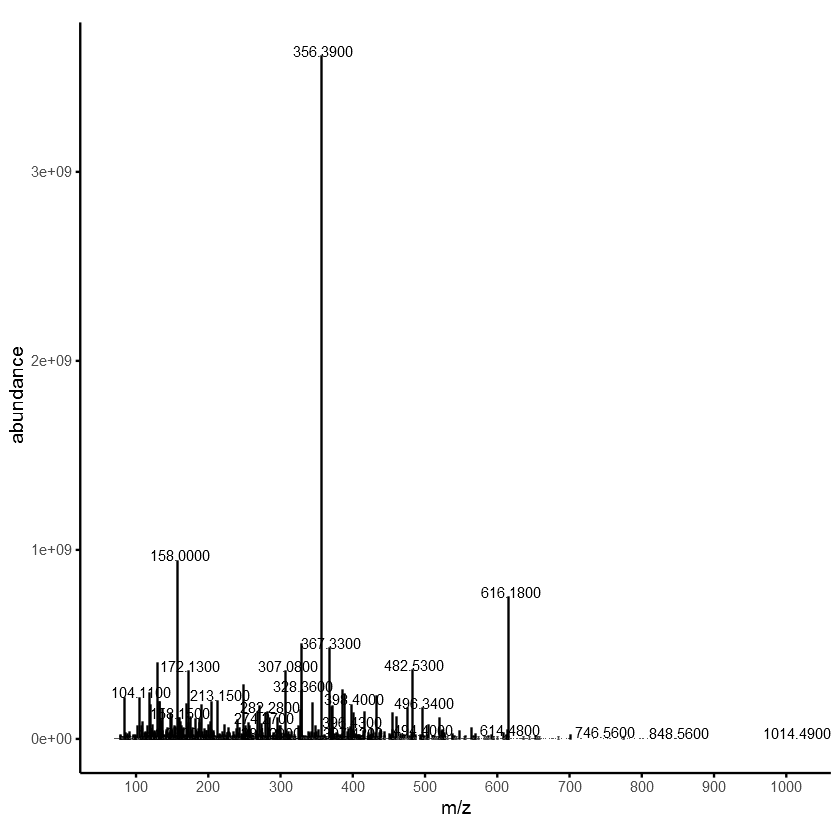

In [14]:
# Original spectrum
Original_Spectrum_plot <- 
    ggplot()+
    geom_bar(data=original_spectrum,aes(x=mz, y=abundance), stat="identity",  
              size=0.5, alpha=1, color="black")+
    geom_text(data=original_spectrum,aes(x=mz, y=abundance,label=mz_label), cex=3, check_overlap = TRUE, vjust=0) +
   scale_x_continuous(breaks = seq(0,1000,100))+
        xlab("m/z") +
        ylab("abundance") +
    theme_minimal() +
        theme(panel.grid.major=element_blank(),panel.grid.minor=element_blank(),
               axis.line=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.ticks=element_line(colour ="black",size=0.5, linetype="solid"),
               panel.background = element_rect(fill="white", colour="white", size=0.5, linetype="solid"),
               legend.position="bottom",
               legend.background = element_rect(fill="white",size=0.25,linetype="blank"),
               legend.title = element_text("DBS Features Filtered"),
               legend.text=element_text(size=6)) +
    theme(aspect.ratio=1)
print(Original_Spectrum_plot)

create MS1 feature spectrum after KMF

In [15]:
KMF_spectrum <- as.data.frame(cbind(KMF_vec,as.numeric(t(output$Kendrickfiltered_MS1features_wgraph)[2:nrow(t(output$Kendrickfiltered_MS1features_wgraph)),2])))
label <- format(round(KMF_vec[,1], 2), nsmall = 4)
KMF_spectrum <- cbind(KMF_spectrum, label)
colnames(KMF_spectrum) <- c("mz","rt","abundance","mz_label")
head(KMF_spectrum)

mz,rt,abundance,mz_label
<dbl>,<dbl>,<dbl>,<fct>
356.3886,7.804624,3.61e+09,356.3900
367.3320,6.990095,4.76e+08,367.3300
482.5283,8.711017,3.61e+08,482.5300
282.2789,9.140700,1.38e+08,282.2800
172.1329,8.829460,3.55e+08,172.1300
370.3669,8.671656,1.66e+08,370.3700


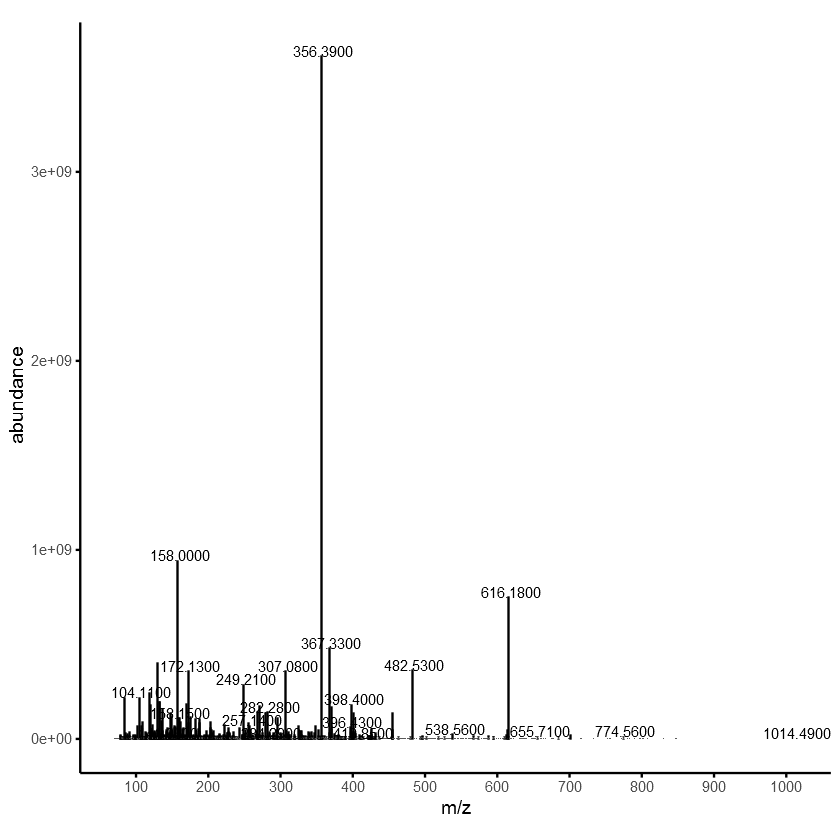

In [16]:
KMF_spectrum_plot <- 
    ggplot()+
    geom_bar(data=KMF_spectrum,aes(x=mz, y=abundance), stat="identity",  
              size=0.5, alpha=1, color="black")+
    geom_text(data=KMF_spectrum,aes(x=mz, y=abundance,label=mz_label), cex=3, check_overlap = TRUE, vjust=0) +
   scale_x_continuous(breaks = seq(0,1000,100))+
        xlab("m/z") +
        ylab("abundance") +
    theme_minimal() +
        theme(panel.grid.major=element_blank(),panel.grid.minor=element_blank(),
               axis.line=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.ticks=element_line(colour ="black",size=0.5, linetype="solid"),
               panel.background = element_rect(fill="white", colour="white", size=0.5, linetype="solid"),
               legend.position="bottom",
               legend.background = element_rect(fill="white",size=0.25,linetype="blank"),
               legend.title = element_text("DBS Extract Features Filtered"),
               legend.text=element_text(size=6)) +
    theme(aspect.ratio=1)
print(KMF_spectrum_plot)

create spectrum of MS1 features removed via KMF

In [17]:
# MS1 Features (calculate MS1 Features that were removed rather than retained)
Filtered_matrix_KMF_wgraph_MS1_plot <- 
   t(data_matrix)[which(((vec[,1] %in% KMF_vec[,1]) & 
                  (vec[,2] %in% KMF_vec[,2])) != TRUE)+1,]

In [19]:
which(((vec[,1] %in% KMF_vec[,1]) & 
                  (vec[,2] %in% KMF_vec[,2])) != TRUE)

[1]    4    6   14   18   22   23   26   40   42   44   47   49   56   57   58
 [16]   61   62   65   69   71   72   73   76   77   78   79   81   84   85   87
 [31]   88   89   93   95   97   98  100  104  105  107  111  117  120  128  129
 [46]  130  138  140  142  144  145  149  150  157  158  161  164  165  167  170
 [61]  171  172  173  174  175  176  178  181  182  188  189  193  199  204  205
 [76]  207  209  211  212  214  215  217  219  225  226  227  229  232  233  234
 [91]  238  240  245  246  247  249  264  269  270  271  274  277  280  282  288
[106]  289  290  296  304  315  322  326  328  329  335  337  338  339  340  342
[121]  343  344  347  356  357  365  368  369  371  373  374  379  382  384  386
[136]  390  397  399  401  406  409  411  416  423  424  425  427  432  440  447
[151]  448  449  450  451  454  455  456  460  463  464  475  480  482  485  486
[166]  487  488  491  496  497  499  501  505  515  531  535  539  540  542  549
[181]  551  552  554  555  557  563  564  566  567  569  580  585  586  588  590
[196]  595  601  603  605  606  614  615  618  627  629  651  658  663  664  665
[211]  666  671  672  676  679  680  684  687  688  689  691  694  695  696  698
[226]  699  701  703  704  705  707  715  716  719  725  726  734  745  747  748
[241]  750  756  759  761  762  767  769  772  773  774  789  794  795  796  798
[256]  803  805  811  818  821  824  830  831  839  843  844  855  859  860  861
[271]  866  868  869  872  881  888  890  896  913  916  922  924  927  929  934
[286]  952  953  956  959  964  972  973  974  975  979  981  982  988  994 1009
[301] 1017 1018 1034 1038 1042 1044 1045 1053 1067 1070 1077 1078 1085 1089 1090
[316] 1091 1092 1102 1103 1112 1115 1116 1117 1118 1122 1129 1137 1165 1168 1175
[331] 1177 1180 1181 1196 1197 1201 1209 1218 1221 1224 1226 1237 1240 1241 1251
[346] 1252 1256 1262 1267 1277 1283 1287 1290 1293 1297 1299 1301 1302 1311 1313
[361] 1314 1316 1332 1338 1342 1346 1370 1372 1378 1381 1383 1384 1386 1387 1389
[376] 1390 1404 1406 1417 1420 1427 1428 1429 1433 1439 1440 1441 1451 1452 1458
[391] 1462 1463 1469 1477 1480 1500 1512 1514 1515 1516 1521 1534 1535 1536 1538
[406] 1539 1542 1545 1546 1547 1548 1558 1563 1580 1588 1597 1600 1601 1605 1611
[421] 1623 1624 1642 1647 1652 1663 1664 1665 1666 1671 1675 1677 1679 1681 1686
[436] 1687 1689 1693 1696 1698 1709 1710 1719 1720 1734 1735 1741 1749 1753 1759
[451] 1765 1777 1778 1782 1790 1803 1809 1810 1818 1826 1828 1831 1838 1850 1860
[466] 1867 1873 1880 1886 1894 1898 1899 1901 1903 1911 1913 1914 1925 1933 1944
[481] 1945 1948 1953 1961 1966 1968 1971 1976 1980 1982 1996 2001 2003 2007 2013
[496] 2015 2017 2019 2020 2023 2040 2043 2046 2073 2082 2083 2086 2088 2090 2091
[511] 2101 2102 2104 2109 2116 2117 2119 2131 2132 2135 2138 2151 2153 2168 2175
[526] 2178 2183 2184 2188 2193 2196 2198 2205 2212 2219 2224 2226 2228 2246 2250
[541] 2251 2253 2254 2264 2266 2268 2274 2278 2281 2283 2285 2289 2301 2303 2304
[556] 2305 2306 2308 2311 2316 2319 2322 2323 2324 2325 2331 2333 2335 2338 2345
[571] 2346 2349 2351 2353 2355 2364 2366 2367 2368 2370 2376 2387 2389 2402 2412
[586] 2414 2416 2418 2420 2421 2424 2425 2427 2429 2430 2433 2434 2449 2453 2456
[601] 2459 2463 2465 2471 2473 2478 2483 2484 2486 2489 2492 2494 2495 2496 2500
[616] 2508 2512 2516 2522 2525 2527 2528 2530 2540 2548 2553 2554 2556 2558 2561
[631] 2573 2601 2610 2634 2636 2647 2650 2652 2654 2666 2667 2678 2682 2691 2709
[646] 2722 2726 2728 2753 2764 2765 2766 2779 2784 2790 2797 2800 2802 2814 2816
[661] 2821 2827 2833 2837 2848 2850 2852 2859 2860 2868 2874 2884 2885 2887 2891
[676] 2901 2907 2914 2918 2945 2950 2954 2959 2973 2978 2983 2990 2991 2992 2994
[691] 2999 3000 3002 3010 3018 3027 3030 3031 3035 3037 3039 3041 3044 3046 3048
[706] 3058 3063 3066 3070 3071 3075 3080 3085 3090 3091 3095 3114 3118 3123 3125
[721] 3128 3129 3131 3147 3163 3167 3173 3175 3180 3181 3183 3186 3192 3196 3198
[736] 3204 3205 3212 3214 3223 32

In [20]:
vec[1:15,]

mz,rt
356.3886,7.8046236
367.3320,6.9900947
482.5283,8.7110173
328.3572,7.9009728
282.2789,9.1407005
328.3573,7.3877783
172.1329,8.8294598
370.3669,8.6716557
249.2060,6.6776203
158.0028,0.2964949


In [21]:
KMF_vec[1:15,]

mz,rt
356.3886,7.8046236
367.3320,6.9900947
482.5283,8.7110173
282.2789,9.1407005
172.1329,8.8294598
370.3669,8.6716557
249.2060,6.6776203
158.0028,0.2964949
104.1069,0.3900365
256.2632,9.1025802


In [22]:
KMF_filtered_features_spectrum <- as.data.frame(cbind(Filtered_matrix_KMF_wgraph_MS1_plot_vec, 
                                                      as.numeric(Filtered_matrix_KMF_wgraph_MS1_plot[,2])))
label <- format(round(Filtered_matrix_KMF_wgraph_MS1_plot_vec[,1], 2), nsmall = 4)
KMF_filtered_features_spectrum <- cbind(KMF_filtered_features_spectrum, label)
colnames(KMF_filtered_features_spectrum) <- c("mz","rt","abundance","mz_label")
head(KMF_filtered_features_spectrum)

mz,rt,abundance,mz_label
<dbl>,<dbl>,<dbl>,<fct>
328.3572,7.900973,5.02e+08,328.3600
328.3573,7.387778,2.51e+08,328.3600
213.1460,5.916102,1.99e+08,213.1500
385.2454,9.385725,2.54e+08,385.2500
191.1641,5.916614,1.75e+08,191.1600
496.3395,8.933042,1.61e+08,496.3400


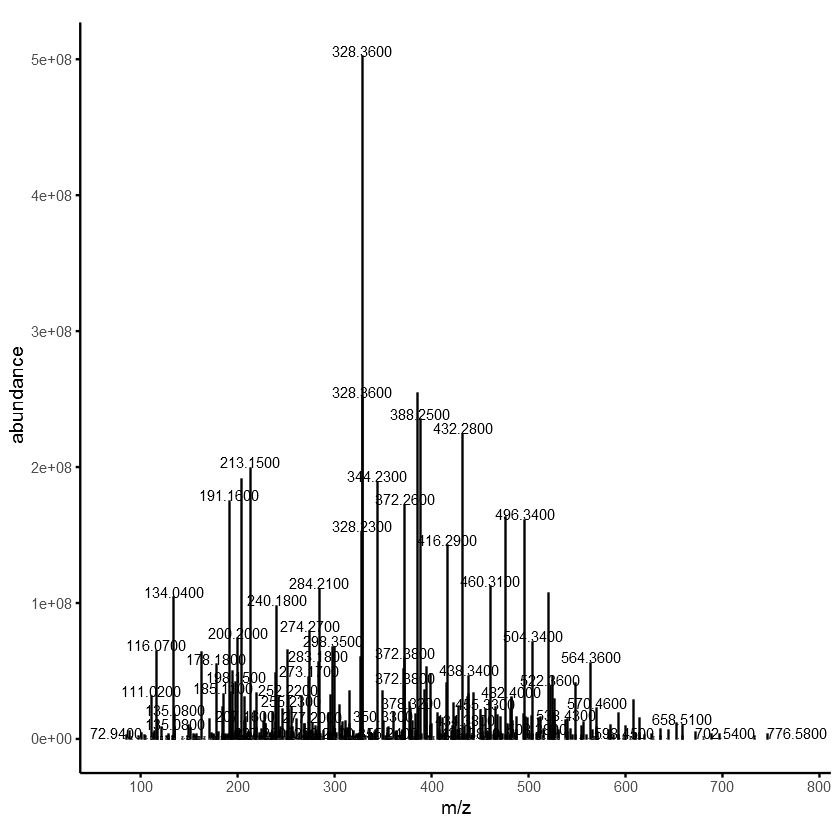

In [23]:
KMF_filtered_features_spectrum_plot <- ggplot()+
    geom_bar(data=KMF_filtered_features_spectrum,aes(x=mz, y=abundance), stat="identity",size=0.5, alpha=1, color="black")+
    geom_text(data=KMF_filtered_features_spectrum,aes(x=mz, y=abundance,label=mz_label), cex=3, check_overlap = TRUE, vjust=0) +
    scale_x_continuous(breaks = seq(0,1000,100))+
    xlab("m/z") +
    ylab("abundance") +
    theme_minimal() +
    theme(panel.grid.major=element_blank(),panel.grid.minor=element_blank(),
               axis.line=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.ticks=element_line(colour ="black",size=0.5, linetype="solid"),
               panel.background = element_rect(fill="white", colour="white", size=0.5, linetype="solid"),
               legend.position="bottom",
               legend.background = element_rect(fill="white",size=0.25,linetype="blank"),
               legend.title = element_text("DBS Features Filtered"),
               legend.text=element_text(size=6)) +
    theme(aspect.ratio=1)
print(KMF_filtered_features_spectrum_plot)

create a) Kendrick mass plot, b) MS1 feature plot, c) MS1 feature spectrum prior and d) after KMF as well as e) MS1 features removed via KMF:

Saving 7.1 x 6.67 in image


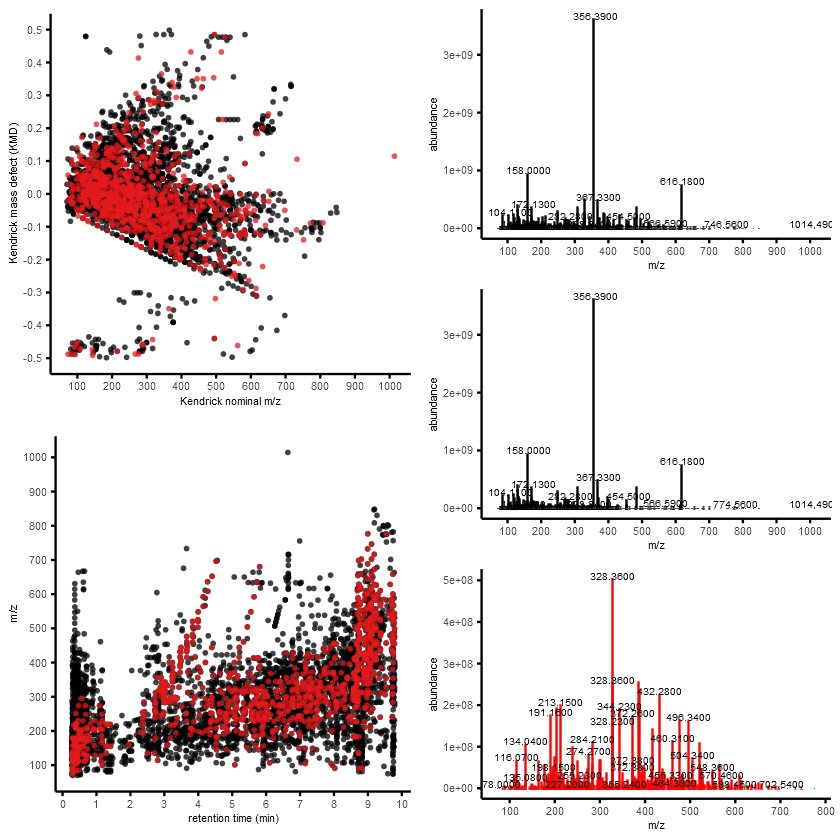

In [24]:
Kendrickplot <- 
    ggplot()+
    geom_point(data=as.data.frame(output$kendrickmassfilterinfo_filtered_wgraph), aes(x=nom_kend, y=msdefect), pch=16, 
               size=1, alpha=0.75, col="black")+
    geom_point(data=kendrickmassfilterinfo_diff,aes(x=nom_kend,y=msdefect), pch=16, 
               size=1, alpha=0.75,  col="#e41a1c")+
    scale_y_continuous(breaks = seq(-0.5,0.5,0.1))+
    scale_x_continuous(breaks = seq(0,1000,100))+
    xlab("Kendrick nominal m/z") +
    ylab("Kendrick mass defect (KMD)") +
    theme_minimal() +
    theme(panel.grid.major=element_blank(),panel.grid.minor=element_blank(),
               axis.line=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.ticks=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.title.x=element_text(size=6),
               axis.title.y=element_text(size=6),
               axis.text=element_text(size=6),
               panel.background = element_rect(fill="white", colour="white", size=0.5, linetype="solid"),
               legend.position="none",
               legend.background = element_rect(fill="white",size=0.25,linetype="blank"),
               legend.title = element_blank(),
               legend.text=element_text(size=6)) +
    theme(aspect.ratio=1)
    
MS1featureplot <- 
    ggplot()+
    geom_point(data=as.data.frame(vec),aes(x=rt, y=mz), pch=16, 
              size=1, alpha=0.75, color="black")+
    geom_point(data=Filtered_matrix_KMF_wgraph_MS1_plot_vec, aes(x=rt, y=mz), pch=16, 
               size=1, alpha=0.75, col="#e41a1c")+
    scale_y_continuous(breaks = seq(0,1000,100))+
    scale_x_continuous(breaks = seq(0,10,1))+
        xlab("retention time (min)") +
        ylab("m/z") +
    theme_minimal() +
        theme(panel.grid.major=element_blank(),panel.grid.minor=element_blank(),
               axis.line=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.ticks=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.title.x=element_text(size=6),
               axis.title.y=element_text(size=6),
               axis.text=element_text(size=6),
               panel.background = element_rect(fill="white", colour="white", size=0.5, linetype="solid"),
               legend.position="none",
               legend.background = element_rect(fill="white",size=0.25,linetype="blank"),
               legend.title = element_blank(),
               legend.text=element_text(size=6)) +
    theme(aspect.ratio=1)

Original_Spectrum_plot <- 
    ggplot()+
    geom_bar(data=original_spectrum,aes(x=mz, y=abundance), stat="identity",  
              size=0.5, alpha=1, color="black")+
    geom_text(data=original_spectrum,aes(x=mz, y=abundance,label=mz_label), size=2, check_overlap = TRUE, vjust=0) +
   scale_x_continuous(breaks = seq(0,1000,100))+
        xlab("m/z") +
        ylab("abundance") +
    theme_minimal() +
        theme(panel.grid.major=element_blank(),panel.grid.minor=element_blank(),
               axis.line=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.ticks=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.title.x=element_text(size=6),
               axis.title.y=element_text(size=6),
               axis.text=element_text(size=6),
               panel.background = element_rect(fill="white", colour="white", size=0.5, linetype="solid"),
               legend.position="none",
               legend.background = element_rect(fill="white",size=0.25,linetype="blank"),
               legend.title = element_blank(),
               legend.text=element_text(size=6)) 

KMF_spectrum_plot <- 
    ggplot()+
    geom_bar(data=KMF_spectrum,aes(x=mz, y=abundance), stat="identity",  
              size=0.5, alpha=1, color="black")+
    geom_text(data=KMF_spectrum,aes(x=mz, y=abundance,label=mz_label), size=2, check_overlap = TRUE, vjust=0) +
   scale_x_continuous(breaks = seq(0,1000,100))+
        xlab("m/z") +
        ylab("abundance") +
    theme_minimal() +
        theme(panel.grid.major=element_blank(),panel.grid.minor=element_blank(),
               axis.line=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.ticks=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.title.x=element_text(size=6),
               axis.title.y=element_text(size=6),
               axis.text=element_text(size=6),
               panel.background = element_rect(fill="white", colour="white", size=0.5, linetype="solid"),
               legend.position="none",
               legend.background = element_rect(fill="white",size=0.25,linetype="blank"),
               legend.title = element_blank(),
               legend.text=element_text(size=6)) 

KMF_filtered_features_spectrum_plot <- ggplot()+
    geom_bar(data=KMF_filtered_features_spectrum,aes(x=mz, y=abundance), stat="identity",size=0.5, alpha=1, color="red")+
    geom_text(data=KMF_filtered_features_spectrum,aes(x=mz, y=abundance,label=mz_label), size=2, check_overlap = TRUE, vjust=0) +
    scale_x_continuous(breaks = seq(0,1000,100))+
    xlab("m/z") +
    ylab("abundance") +
    theme_minimal() +
    theme(panel.grid.major=element_blank(),panel.grid.minor=element_blank(),
               axis.line=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.ticks=element_line(colour ="black",size=0.5, linetype="solid"),
               axis.title.x=element_text(size=6),
               axis.title.y=element_text(size=6),
               axis.text=element_text(size=6),
               panel.background = element_rect(fill="white", colour="white", size=0.5, linetype="solid"),
               legend.position="none",
               legend.background = element_rect(fill="white",size=0.25,linetype="blank"),
               legend.title = element_blank(),
               legend.text=element_text(size=6))  

lay <- rbind(c(1,3),
             c(1,3),
             c(1,4),
             c(2,4),
             c(2,5),
             c(2,5))
plot <- grid.arrange(Kendrickplot,MS1featureplot,Original_Spectrum_plot,KMF_spectrum_plot,KMF_filtered_features_spectrum_plot, layout_matrix = lay)

ggsave("KMF_Figure_PEG400_Autism_V1.1_NOS5.pdf", plot, scale=1, width=7.1, units="in")

save output tables to files

In [25]:
# write .csv table containing the KMF info matrix
write.csv(kendrickmassfilterinfo_diff, "PEG_KMF_infomatrix.csv", row.names=FALSE)

# write .csv table containing MS1 features remaining after Kendrick mass filtering
write.csv(output$Kendrickfiltered_MS1features_wgraph, "PEG_KMF_resultingdatamatrix.csv",row.names=FALSE)

# write .csv table of MS1 features removed from the data via the Kendrick mass filter
write.csv(Filtered_matrix_KMF_wgraph_MS1_plot_vec, "PEG_KMF_featuresfiltered.csv", row.names=FALSE)